In [1]:
# Utils
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import time
#import _pickle as pickle
import pickle
import re, sys, unidecode
#import unidecode

# Representation
import nltk
from nltk.corpus import stopwords
import scikitplot.plotters as skplt

# Para extraer el texto plano del HTML
from bs4 import BeautifulSoup

plt.style.use('fivethirtyeight')


/root/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Load Data

In [2]:
root_path = "../"
path_data_raw = root_path + "data/raw/"
#dfNoticias = pd.read_pickle(path_data_raw+"dfNoticias")
dfNoticias = pd.read_pickle(path_data_raw+"dfNoticiasV2.pan")

# Data info

In [3]:
dfNoticias.head()

Cuerpo       Fecha   Hora  \
0  \n<p style="text-align: justify;">La president...  2013-11-20  21:37   
1  \n<p>Por problemas de agenda de la jueza del <...  2013-11-20  17:09   
2  \n<p>El <strong>presidente uruguayo</strong>, ...  2013-11-20  12:45   
3  \n<p>El <strong>presidente uruguayo</strong>, ...  2013-11-20  12:45   
4  \n<p><strong>El Reino Unido considera que el E...  2013-11-20  11:43   

               ID                                            Resumen  \
0  20131120214139  \nEste fue el primer acto público de la mandat...   
1  20131120164254  \nAudiencia se realizará el próximo lunes 2 de...   
2  20131120124736  \nPresidente uruguayo está afectado por un "es...   
3  20131120080910  \nPresidente uruguayo está afectado por un "es...   
4  20131120114123  \nGobierno hispano ha ejercido medidas de pres...   

  Seccion_1 Seccion_2 Seccion_3 Subtema_1 Subtema_2 Subtema_3  \
0     Mundo      None      None      None      None      None   
1      País      None      None      None      None      None   
2     Mundo      None      None      None      None      None   
3     Mundo      None      None      None      None      None   
4     Mundo      None      None      None      None      None   

                   Tema_1 Tema_2 Tema_3  \
0               Argentina   None   None   
1  Región de La Araucanía   None   None   
2                 Uruguay   None   None   
3                 Uruguay   None   None   
4                  Europa   None   None   

                                             Titular         Type  
0  \nPresidenta argentina tomó juramento a tres n...  fid_noticia  
1  \nNuevamente se postergó preparación del juici...  fid_noticia  
2  \nResfrío que afecta a José Mujica obligó a su...  fid_noticia  
3  \nResfrío que afecta a José Mujica obligó a su...  fid_noticia  
4  \nReino Unido arremete contra España ante incu...  fid_noticia

In [4]:
dfNoticias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367148 entries, 0 to 367147
Data columns (total 16 columns):
Cuerpo       367148 non-null object
Fecha        367148 non-null object
Hora         367148 non-null object
ID           367148 non-null object
Resumen      365882 non-null object
Seccion_1    366849 non-null object
Seccion_2    195365 non-null object
Seccion_3    61936 non-null object
Subtema_1    266658 non-null object
Subtema_2    119065 non-null object
Subtema_3    41267 non-null object
Tema_1       364295 non-null object
Tema_2       187913 non-null object
Tema_3       60257 non-null object
Titular      367148 non-null object
Type         367147 non-null object
dtypes: object(16)
memory usage: 44.8+ MB


### elementos nulos

Existen noticias con el cuerpo en nulo, primeras en ser borradas.
Tambien con seccion_1 en nulo, borrar tambien.

In [5]:
pd.isnull(dfNoticias).any()

Cuerpo       False
Fecha        False
Hora         False
ID           False
Resumen       True
Seccion_1     True
Seccion_2     True
Seccion_3     True
Subtema_1     True
Subtema_2     True
Subtema_3     True
Tema_1        True
Tema_2        True
Tema_3        True
Titular      False
Type          True
dtype: bool

### Cantidades totales por cada columnas, cantidad de elementos no repetidos, elemento mas repetido y la cantidad de veces que se repite este

Aca se pueden ver las cantidades de noticias etiquetadas y la cantidad de etiquetas, para seccionx, temax y subtemaX

620 noticias con cuerpo repetido, "/n/n", borrar tambien.

In [6]:
dfNoticias.describe(include="all")

Cuerpo       Fecha    Hora              ID Resumen Seccion_1  \
count   367148      367148  367148          367148  365882    366849   
unique  351751        3210    1440          367148  348209         9   
top       \n\n  2018-06-07   00:01  20160702155615    \n\n  Deportes   
freq       620         198    1015               1    1203    128151   

       Seccion_2 Seccion_3  Subtema_1          Subtema_2  \
count     195365     61936     266658             119065   
unique        10         9       1540               1346   
top     Deportes  Deportes  Colo Colo  Selección chilena   
freq       93884     33965       5441               4161   

                      Subtema_3  Tema_1  Tema_2  Tema_3               Titular  \
count                     41267  364295  187913   60257                367148   
unique                     1027     244     244     233                351300   
top     Chilenos en el exterior  Fútbol  Fútbol  Fútbol  \nEstrenos de cine\n   
freq                       2163   68747   57256   24256                    37   

               Type  
count        367147  
unique            5  
top     fid_noticia  
freq         366508

### Ejemplo texto de una noticia
Falta limpar html en texto, caracteres como /n

In [7]:
dfNoticias["Cuerpo"].iloc[100]

'\n<p style="text-align: justify;">Tras haber jugado poco más de 30 minutos ante Brasil y de no haber tenido acción ante Inglaterra, el mediocampista de la selección chilena<strong> Jorge Valdivia manifestó su deseo de superar sus continuas lesiones y de llegar de la mejor manera al Mundial de Brasil 2014.</strong></p>\n<p style="text-align: justify;"><strong>"Soy el primero en querer llegar al Mundial y el primero en pelear un cupo para llegar a Brasil. Depende de mí, había estado bien y entrenando bien, pero una lesión antigua impidió que pudiese jugar como quería", dijo</strong> Valdivia en Toronto.</p>\n<p style="text-align: justify;">"Es una lesión antigua y me incomodó, así es que ahora queda descansar para volver a mi equipo", añadió.</p>\n<p style="text-align: justify;">Sobre el duelo ante Brasil, Valdivia dijo que <strong>"los jugadores que estuvimos supimos llevar el partido amistoso. Siempre es difícil jugar ante Brasil, más aun en una que estaba imposible, pero siempre hay 

# Analisis Etiquetas

In [8]:
def labels_info(labels_name):
    labels_count=dfNoticias[labels_name].value_counts(ascending=True)
    total = len(labels_count)
    labels_count.plot.barh(color='DarkOrange',
                           figsize=(10,round(total/2)),
                           title="Labels " + labels_name + ", total "+ str(total),
                           grid=True)


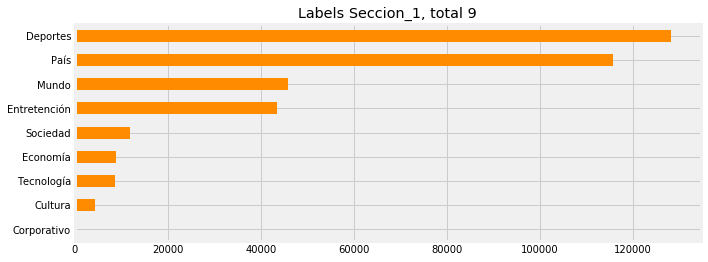

In [9]:
labels_info("Seccion_1")


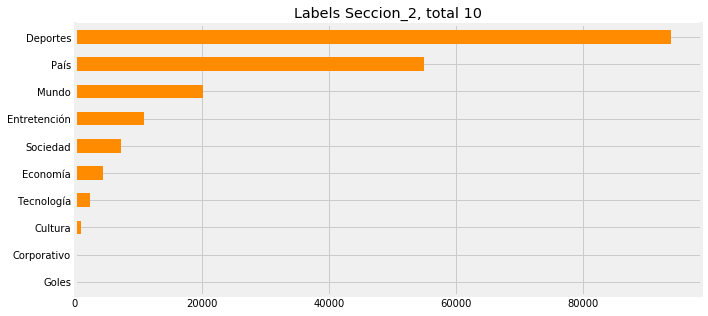

In [10]:
labels_info("Seccion_2")


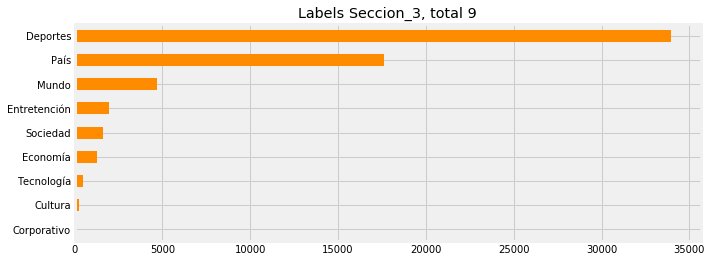

In [11]:
labels_info("Seccion_3")


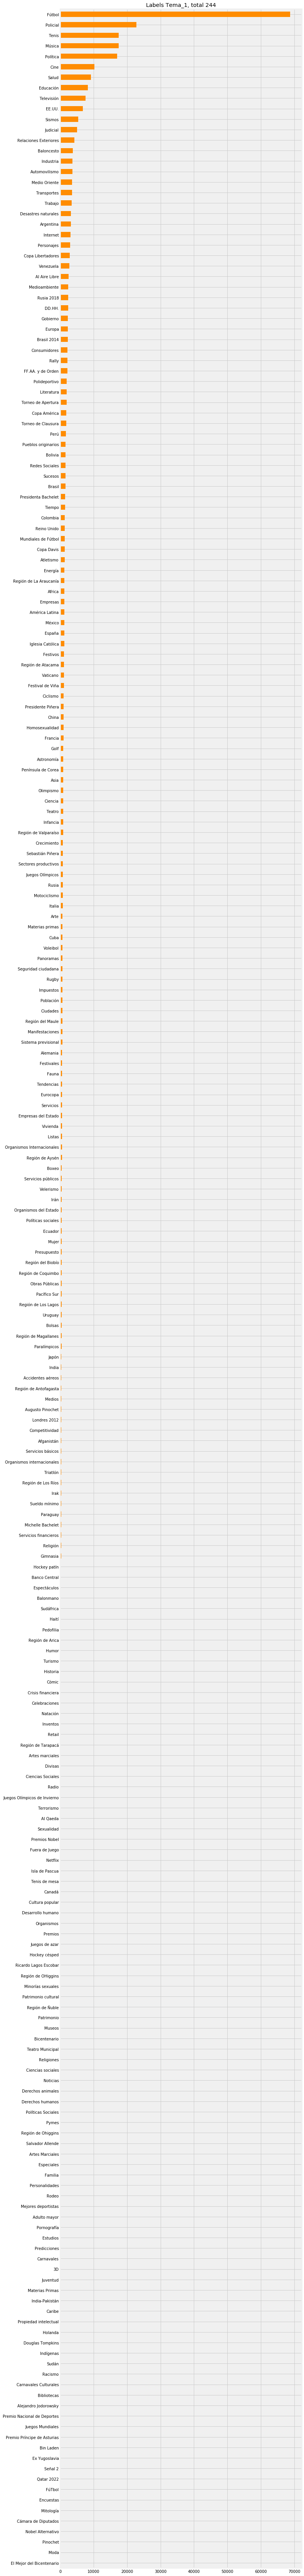

In [12]:
labels_info("Tema_1")


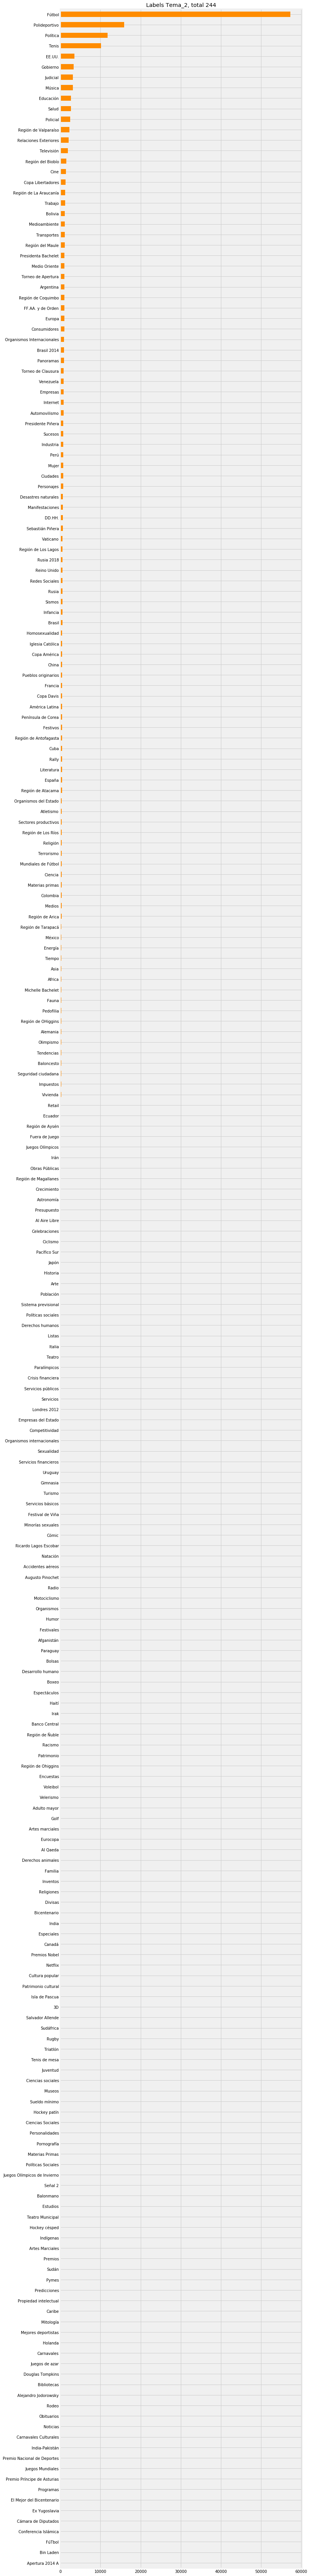

In [13]:
labels_info("Tema_2")


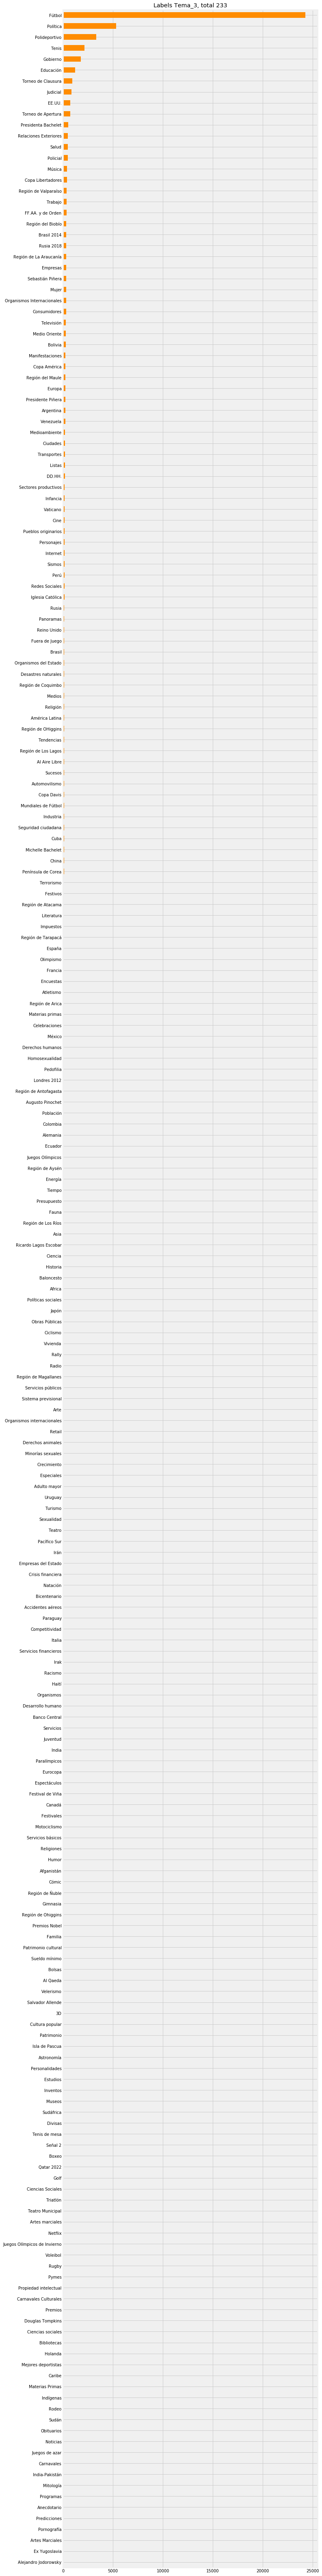

In [14]:
labels_info("Tema_3")


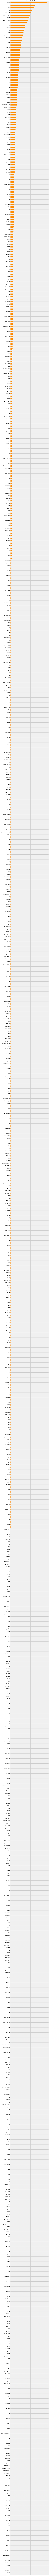

In [15]:
labels_info("Subtema_1")


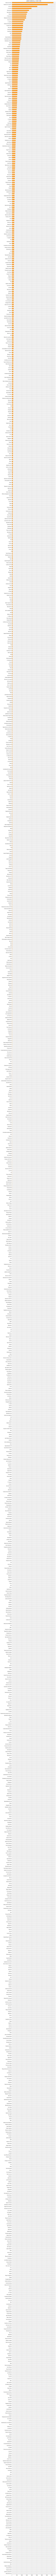

In [16]:
labels_info("Subtema_2")


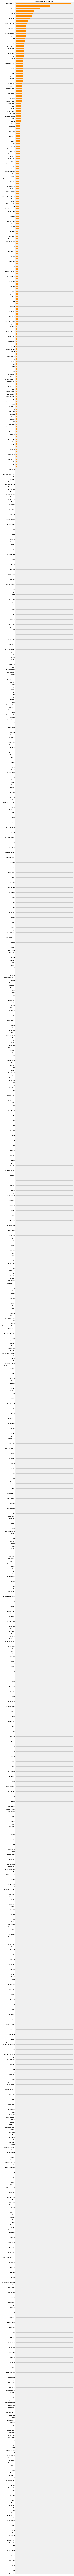

In [17]:
labels_info("Subtema_3")


### Largos de noticias

Histograma, muy pocas noticas arriba de 2000 palabras. grafico distorsionado por noticias muy largas (mas de 2000 palabras)

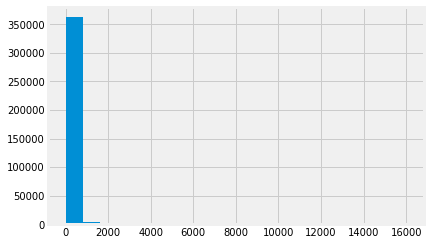

In [18]:
dfNoticias["Cuerpo"].map(lambda x:len(str(x).split(" ")), na_action=None).hist(bins=20)

### hist solo noticias con menos de mil palabras 

In [19]:
# Añador largo de noticias como campo en var tmp
dfNoticiasTmp = dfNoticias.copy()
words_cuerpo = dfNoticiasTmp["Cuerpo"].map(lambda x:len(str(x).split(" ")), na_action=None)
dfNoticiasTmp["largo_noticia"] = words_cuerpo.values

cantiadad noticias con mas de 1000 palabras : 2011


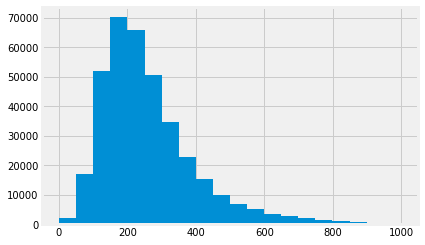

In [20]:
filtered_data = dfNoticiasTmp[dfNoticiasTmp.largo_noticia < 1000]
filtered_data["Cuerpo"].map(lambda x:len(str(x).split(" ")), na_action=None).hist(bins=20)
print( "cantiadad noticias con mas de 1000 palabras : " + str(dfNoticias.shape[0] - filtered_data.shape[0]) )


# Cleaning

Limpieza de datos
* Cuerpo en null
* seccion 1 en null
* cuerpo igual a /n/n
* noticias repetidas


In [21]:
dfNoticiasClean = dfNoticias
dfNoticiasClean = dfNoticiasClean.dropna(subset=['Cuerpo', 'Seccion_1'])
print( "noticias eliminadas,  sin cuerpo o label : "+ str( dfNoticias.shape[0]-dfNoticiasClean.shape[0] ))

noticias eliminadas,  sin cuerpo o label : 299


In [22]:
tmp = dfNoticiasClean.shape[0]
dfNoticiasClean = dfNoticiasClean[dfNoticiasClean.Cuerpo != "\n\n"]
print( "noticias eliminadas,  con cuerpo igual a '/n/n' : "+ str( tmp-dfNoticiasClean.shape[0] ))

noticias eliminadas,  con cuerpo igual a '/n/n' : 389


In [23]:
print("cantidad noticias con cuerpo repetido : " + str( sum(dfNoticiasClean.duplicated(subset=['Cuerpo']))))


cantidad noticias con cuerpo repetido : 14778


In [24]:
#print("cantidad noticias con todos los campos repetidos : " + str(sum(dfNoticiasClean.duplicated(subset=['Cuerpo', 'Seccion_1','Tema1','Subtema_1','Seccion_2','Tema2','Subtema_2','Seccion_3','Tema3','Subtema_3']))) )


Borro noticas cuerpo repetidas

In [25]:

dfNoticiasClean = dfNoticiasClean.drop_duplicates(subset=['Cuerpo'])

clean html text

In [26]:
type(dfNoticiasClean["Cuerpo"][0])

str

In [27]:

def cleanHtml(text):
    return text

    if type(text) == str : 
        soup = BeautifulSoup(text, 'html.parser')

        # kill all script and style elements
        for script in soup(["script", "style"]):
            script.extract()    # rip it out    

        # get text
        text = soup.get_text()
        return text
    else:
        return text
clases = ["Cuerpo","Resumen"]

for column in clases:
    dfNoticiasClean[column] = dfNoticiasClean[column].map( cleanHtml , na_action=None)

#dfNoticiasClean.describe(exclude=[np.number])

KeyboardInterrupt: 

In [ ]:
a = 5

## limpiado etiquetas

* remuevo categoria goles en seccion 2 , error en etiquetado
* remuevo caracteres no alpha-num, puntuacion y paso a minusculas

In [ ]:
dfNoticiasClean = dfNoticiasClean[dfNoticiasClean.Seccion_2 !='Goles']

In [ ]:
dfNoticiasClean.describe(exclude=[np.number])

Limpio texto de etiquetas clase y subclase, mas de 100 clases repetidas encontradas despues de la limpieza

In [ ]:
def simple_clean(string):
    if type(string) == str :
        string = ''.join(x for x in string if (x.isalpha() or x ==" " ) )
        string= string.lower()
        return unidecode.unidecode(string)
    else:
        return string

In [ ]:
clases = ["Seccion_1","Seccion_2","Seccion_3","Tema_1","Tema_2","Tema_3","Subtema_1","Subtema_2","Subtema_3"]

for column in clases:
    dfNoticiasClean[column] = dfNoticiasClean[column].map( simple_clean , na_action=None)

dfNoticiasClean.describe(exclude=[np.number])

# guardado data limpia

In [ ]:
#pickle.dump( dfNoticiasClean, open( root_path + "data/clean/dfNoticiasClean.p", "wb" ) )
pickle.dump( dfNoticiasClean, open( root_path + "data/clean/dfNoticiasCleanV2.p", "wb" ) )